In [1]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# What is my project?

In this project, I developed a multi-layer neural network to perform a regression task on a Valorant player statistics dataset containing data from the 2023 Champions run. This is the same data I used for Unit 3 and 7. The goal is to predict ACS (Average Combat Score, a generalized statistic used to describe player performance) from ADPR and KPR as from my Unit 7 project I identified ADPR and KPR as strong indicators of ACS, but in that same project the GLM had the best elpd_loo. However, when looking at my data I don't believe it is purely linear so it would be interesting to see how a neural network handles this task. I also want to make a 2nd NN where headshot is predicting ACS because I know that headshot isn't a linear predictor (as the best player in the world right now has a headshot of ~20% while the highest headshot is at 47% and that player is near the bottom) so it would be interesting to see the interaction there. I don't want to include it in a single neural network because I know from previous projects that it isn't that strong of a predictor, but it would be interesting to see how the NN handles it. 

# The Data...

In [76]:
data = pd.read_csv("https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_3/players_stats.csv")

In [77]:
data = data.query('Tournament == "Valorant Champions 2023" & ~Agents.str.contains(",") & `Match Type` == "All Match Types"')

In [78]:
data

,Tournament,Stage,Match Type,Player,Teams,Agents,Rounds Played,Rating,Average Combat Score,Kills:Deaths,...,First Deaths Per Round,Headshot %,Clutch Success %,Clutches (won/played),Maximum Kills in a Single Map,Kills,Deaths,Assists,First Kills,First Deaths
2008,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,kayo,24,1.42,254.0,1.71,...,0.00,31%,20%,5-Jan,24,24,14,13,0,0
2009,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,killjoy,20,0.99,172.0,0.92,...,0.00,35%,67%,3-Feb,12,12,13,4,2,0
2010,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,viper,58,0.95,168.0,0.84,...,0.05,25%,10%,10-Jan,15,32,38,12,2,3
2011,Valorant Champions 2023,All Stages,All Match Types,d4v41,Paper Rex,skye,256,1.10,196.0,1.08,...,0.02,31%,13%,30-Apr,23,175,162,124,9,6
2013,Valorant Champions 2023,All Stages,All Match Types,mindfreak,Paper Rex,astra,177,1.04,167.0,1.05,...,0.05,29%,19%,Jun-32,23,109,104,71,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303,Valorant Champions 2023,All Stages,All Match Types,xeta,T1,sova,20,0.97,189.0,0.86,...,0.10,17%,NaN,0/1,12,12,14,4,0,2
2305,Valorant Champions 2023,All Stages,All Match Types,ban,T1,harbor,86,0.84,178.0,0.83,...,0.16,31%,20%,10-Feb,16,55,66,31,2,14
2306,Valorant Champions 2023,All Stages,All Match Types,ban,T1,omen,43,0.88,173.0,0.78,...,0.05,39%,NaN,0/9,15,25,32,12,4,2
2308,Valorant Champions 2023,All Stages,All Match Types,Sayaplayer,T1,jett,106,1.07,224.0,1.08,...,0.09,27%,31%,13-Apr,20,84,78,12,19,10


In [79]:
dataNN = data[['Average Combat Score', 'Kills Per Round', 'Average Damage Per Round', 'Headshot %']]
dataNN['Headshot %'] = dataNN['Headshot %'].str.rstrip('%').astype('float')
dataNN = dataNN.dropna()

C:\Users\ashwi\AppData\Local\Temp\ipykernel_7576\1210349704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNN['Headshot %'] = dataNN['Headshot %'].str.rstrip('%').astype('float')


In [80]:
dataNN = dataNN.rename(columns={'Average Combat Score' : 'ACS', 'Average Damage Per Round' : 'ADPR', 'Kills Per Round': 'KPR', 'Headshot %': 'HS%'})

In [81]:
dataNN

,ACS,KPR,ADPR,HS%
2008,254.0,1.00,172.0,31.0
2009,172.0,0.60,132.0,35.0
2010,168.0,0.55,120.0,25.0
2011,196.0,0.68,125.0,31.0
2013,167.0,0.62,114.0,29.0
...,...,...,...,...
2303,189.0,0.60,133.0,17.0
2305,178.0,0.64,111.0,31.0
2306,173.0,0.58,108.0,39.0
2308,224.0,0.79,146.0,27.0


In [82]:
matrix = dataNN.to_numpy()
tensor = torch.from_numpy(matrix)

In [83]:
tensor.shape

torch.Size([225, 4])

# ADPR and KPR predicting ACS 

In [84]:
X_np = dataNN[['ADPR', 'KPR']].to_numpy()
y_np = dataNN['ACS'].to_numpy()

In [85]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)  

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_np, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

In [ ]:
model_1 = nn.Sequential(
    nn.Linear(2, 16),  
    nn.ReLU(),
    nn.Linear(16, 8),  
    nn.ReLU(),
    nn.Linear(8, 1)
)

In [87]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.0001)

In [88]:
model_1 = model_1.float()

In [89]:
epochs = 9200
for epoch in range(epochs):
    model_1.train()
    y_pred = model_1(X_train)                      
    loss = loss_fn(y_pred, y_train)               

    optimizer.zero_grad()                        
    loss.backward()                                
    optimizer.step()                           

    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch:5d} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch:     0 | Train loss: 38605.19531, Test loss: 38818.26562
Epoch:   200 | Train loss: 82.90628, Test loss: 77.29592
Epoch:   400 | Train loss: 72.94887, Test loss: 64.27857
Epoch:   600 | Train loss: 70.37933, Test loss: 61.03805
Epoch:   800 | Train loss: 69.29084, Test loss: 59.76074
Epoch:  1000 | Train loss: 68.71902, Test loss: 59.13774
Epoch:  1200 | Train loss: 68.36418, Test loss: 58.77315
Epoch:  1400 | Train loss: 68.10736, Test loss: 58.51741
Epoch:  1600 | Train loss: 67.89709, Test loss: 58.30983
Epoch:  1800 | Train loss: 67.71040, Test loss: 58.12506
Epoch:  2000 | Train loss: 67.53692, Test loss: 57.95241
Epoch:  2200 | Train loss: 67.37187, Test loss: 57.78725
Epoch:  2400 | Train loss: 67.21288, Test loss: 57.62770
Epoch:  2600 | Train loss: 67.05884, Test loss: 57.47261
Epoch:  2800 | Train loss: 66.90913, Test loss: 57.32177
Epoch:  3000 | Train loss: 66.76333, Test loss: 57.17486
Epoch:  3200 | Train loss: 66.62128, Test loss: 57.03158
Epoch:  3400 | Train loss

In [90]:
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)


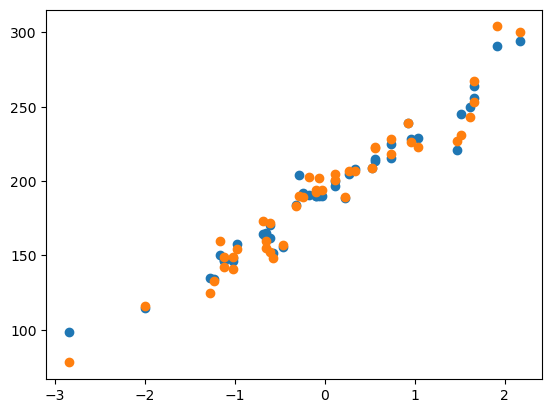

In [91]:
plt.scatter(X_test[:,0].detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test[:,0].detach().numpy(),y_test.detach().numpy())

The first scatter shows how the model’s predictions and observed values line up against Average Damage Per Round (ADPR). There’s a clear upward trend as higher ADPR generally corresponds to higher ACS. The model captures this relationship really well. We are also able to get those curves towards the extremes that out linear model from the previous unit was unable to get. Even so at the extreme ADPR values the predictions begin to diverge (the lower ADPR values mainly) suggesting the network underfits the left tail of the distribution. This shows that while ADPR is a strong single predictor of ACS, the model’s capacity or training data at that extreme could be improved. But overall our model does do a really good job. 

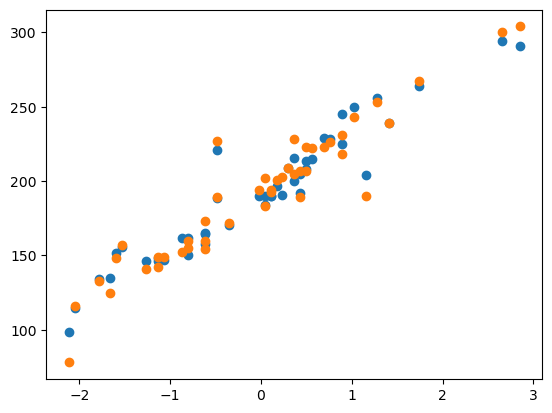

In [92]:
plt.scatter(X_test[:,1].detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test[:,1].detach().numpy(),y_test.detach().numpy())

In the second scatter (kills per round, KPR), we again see a positive relationship with ACS, but the spread is noticeably wider than with ADPR. Although the network’s predictions follow the general upward trend, there’s more variance around the predicted. Many predicted values either overshoot or undershoot the real ACS for a given KPR. This suggests KPR carries signal but is a noisier indicator of overall combat performance than raw damage. The network may benefit from putting less weight on KPR alone or combining it with other features to reduce this scatter. I do thing it does get the general shape really well. There are signing of overfitting as we are predicting outliers at times but overall I am very happy with the graph.



# Headshot predicting ACS 

In [104]:
X_np = dataNN[['HS%']].to_numpy()
y_np = dataNN['ACS'].to_numpy()

In [105]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)  

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_np, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

In [106]:
model_2 = nn.Sequential(
    nn.Linear(1, 16),  
    nn.ReLU(),
    nn.Linear(16, 8),  
    nn.ReLU(),
    nn.Linear(8, 1)
)

In [107]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.0001)

In [108]:
model_2 = model_2.float()

In [109]:
epochs = 9200
for epoch in range(epochs):
    model_1.train()
    y_pred = model_2(X_train)                      
    loss = loss_fn(y_pred, y_train)               

    optimizer.zero_grad()                        
    loss.backward()                                
    optimizer.step()                           

    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch:5d} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch:     0 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:   200 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:   400 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:   600 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:   800 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  1000 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  1200 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  1400 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  1600 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  1800 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  2000 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  2200 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  2400 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  2600 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  2800 | Train loss: 38495.21094, Test loss: 38817.00000
Epoch:  3000 | Train loss: 38495.21094, Test loss: 3881

In [110]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(X_test)


In [112]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

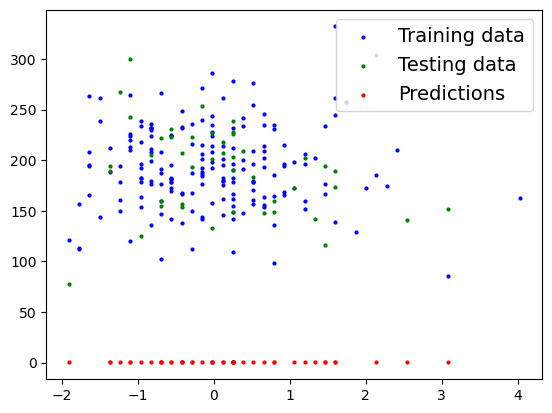

In [113]:
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test)

# Plot data and predictions
plot_predictions(predictions=y_preds);

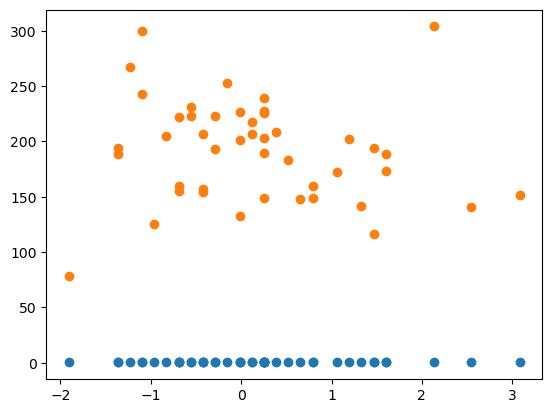

In [111]:
plt.scatter(X_test.detach().numpy(),y_preds.detach().numpy())

#plots test data
plt.scatter(X_test.detach().numpy(),y_test.detach().numpy())

The third figure plots Headshot % against ACS. Here, the predicted is  horizontal there’s barely any trend. In other words, headshot rate alone explains very little of the variance in ACS. The model recognizes this by assigning a zero slope, so it essentially ignores headshot % when making its predictions. This confirms that accuracy of shots matters less than sheer volume of damage and kills for driving ACS. This makes sense when I think about it more because while a high headshot% means you will be good at duels, that isn't the majority of fights taken in Valorant. It is game where you are supposed to use your utility effectivly to get kills. So a high headshot would matter less if you are constantly taking fights where you are stunned or blinded by good enemy utility. Also spraying through smokes is an effective way to get kills as you could hear footstep of people behind smokes and shooting through the smoke would allowing you to deal damage to them, if you get lucky then you could get a kill. This strategy reduces your headshot percentage a lot because since the enemy is blocked off by a smoke, it is hard to hit their head. 



# Conclusion

Overall, the two input network combining ADPR and KPR succeeds in capturing the relationship with ACS, the predictions track the rise in damage and kills per round for most mid-range values yet there are some problems with the tails and overfitting. In contrast, the single-input headshot-percentage network learns virtually no slope confirming that shot accuracy alone offers almost no explanatory power. Taken together, these results show that ADPR is the strongest predictor of ACS, KPR adds useful but noisy signal, and headshot rate contributes negligibly when isolated. 